In [1]:
import sys
import numpy as np
import argparse
from math import *

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import geom
import sonalleve
import transducers
import PBHE_CUDA

import importlib

import matplotlib.image as image
import matplotlib.pyplot as plt

import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

plt.rc('font', family='sans-serif', size=24)

def plotTraj(vec,maxR_mm=10,dR_mm=4,z_mm=140):
    points,nt,numSon = ablation_utils.contstruct_circ_sonication_points(maxR_mm,dR_mm,z_mm,vec[0],vec[1],vec[2])
    plt.plot(points[:,0], points[:,1], '*-')
    return points


%matplotlib inline

In [40]:
importlib.reload(ablation_utils)

<module 'ablation_utils' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims\\ablation_utils.py'>

In [2]:
rho=1000
Cp=4100
c0=1540
f0=1.2e6
k0=f0*2*pi/c0
ktdiffusion=0.6

uxyz = sonalleve.get_sonalleve_xdc_vecs()
unvec = sonalleve.get_sonalleve_xdc_normals()

In [8]:
dataType=np.float32
nt=30
nx=64; ny=64; nz=64;

simPhysGrid = ablation_utils.makeSimPhysGrid(dtype=dataType,nx=nx,ny=ny,nz=nz,nt=nt,dt=0.1,rho=rho,Cp=Cp,f0=f0,c0=c0,ktherm=ktdiffusion)


[T,xrp,yrp,zrp]=[simPhysGrid[k] for k in tuple('T,xrp,yrp,zrp'.split(','))]
(dx,dy,dz,dt)=simPhysGrid['dtxyz']

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]


zsliceMask = np.zeros([nx,ny,nz],dtype=bool)
axsliceMask = np.zeros([nx,ny,nz],dtype=bool)

yi=floor(ny/2)
zsliceMask[:,:,focplaneZpix]=True
axsliceMask[:,yi,:]=True


CEM=np.zeros([nx,ny,nz],dtype=dataType)
CEM0=np.zeros_like(CEM)

ROION=   geom.roiGen([[-0.0015,0.0, 0.14]], lambda x,y,z: geom.inEllipse(x,y,z, 0.008, 0.008,0.015),gxp,gyp,gzp)    
ROIEXTRA=geom.roiGen([[-0.0015,0., 0.14]], lambda x,y,z: geom.inEllipse(x,y,z,0.01,0.01,0.04),gxp,gyp,gzp )
ROIOFF = np.logical_and( ROIEXTRA, np.logical_not(ROION))

In [4]:
simPhysGrid.keys()

dict_keys(['yrp', 'Tmesh', 'kmesh', 'c0', 'rho', 'kt', 'xrp', 'Tdot', 'rhoCpmesh', 'zrp', 'dtxyz', 'k0', 'T', 'rhoCp', 'Tdotmesh'])

In [306]:
simPhysGrid['k0']

4895.9885510490285

In [4]:
PBHE_CUDA.ResetGPU()
PBHE_CUDA.Create_Global_GPU_Session32(*T.shape)

In [389]:
def L2norm(arg):
    return np.sqrt(np.sum(np.abs(arg)**2))

In [455]:
T[0] = 37.0
RSkeys=dict(subsampN=10, ROC=0.14, subsampDiam=0.0066, gpublocks=512)

calibFocus = [0.0,0.005,0.14]

calibAmp = transducers.get_focused_element_vals(simPhysGrid['k0'],uxyz,[calibFocus], [1] )

pp0=transducers.calc_pressure_profile_cuda(simPhysGrid['k0'], uxyz, unvec, calibAmp , [calibFocus[0]], [calibFocus[1]], [calibFocus[2]], **RSkeys)
#pp0 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, calibAmp , xrp, yrp, zrp, **RSkeys)  
Ip0 = np.abs(pp0)**2 / (2.0*rho*c0)

Ispta0 = 1e7

calibrationGain = (Ispta0/np.max(Ip0))

L2powRenorm = sqrt(calibrationGain)*L2norm(calibAmp)

MM=8
dd=0.008
uamp = transducers.get_focused_element_vals(simPhysGrid['k0'], uxyz, [[0,0,0.14]], [1], L2renorm=L2powRenorm )
uamp00 = L2powRenorm* calibAmp/L2norm(calibAmp)
uamp1 = transducers.get_focused_element_vals(simPhysGrid['k0'], uxyz, geom.ring(dd,MM,z=0.14)[0], np.ones(MM)*np.exp(1j*np.arange(0,MM)*pi), L2renorm=L2powRenorm )
uamp2 = transducers.get_focused_element_vals(simPhysGrid['k0'],uxyz,[[0,0.01,0.14]], [1], L2renorm=L2powRenorm )


In [410]:
ptest = transducers.calc_pressure_profile_cuda(simPhysGrid['k0'], uxyz, unvec, uamp , [0], [0], [0.14], **RSkeys)
ptest00 = transducers.calc_pressure_profile_cuda(simPhysGrid['k0'], uxyz, unvec, uamp00 ,  [0], [0], [0.14], **RSkeys)

Ip0, np.abs(ptest)**2/(2.0*rho*c0), np.abs(ptest00)**2/(2.0*rho*c0)

(array([  4.03790196e-11]),
 array([  2.23264516e+09]),
 array([ 4939868.41898628]))

In [411]:
np.abs(uamp[0]), np.abs(uamp00[0])

(323945.39786102431, 292827.57048480469)

In [414]:
np.sum(np.abs(uamp1)**2) / np.sum(np.abs(uamp)**2)

0.99999999999999867

In [278]:
(L2powRenorm)

409368.4323951507

In [81]:
MM=9
dd=0.006
uamp1 = transducers.get_focused_element_vals(simPhysGrid['k0'], uxyz, geom.ring(dd,MM,z=0.14)[0], np.ones(MM)*np.exp(1j*np.arange(0,MM)*pi), L1renorm=sqrt(powRenorm) )


In [307]:
sqrt(powRenorm)

6624996.119707272

In [308]:
p0f = transducers.calc_pressure_profile_cuda(simPhysGrid['k0'], uxyz, unvec, uamp, [0.0], [0.0], [0.14]  ,**RSkeys)

mf_radii = np.arange(0.0002,0.011,0.0002)
nf = 3

ratios = np.zeros([len(mf_radii),nf])

for ri in range(len(mf_radii)):
    pxyz=geom.ring(mf_radii[ri],nf,z=0.14)[0]
    
    uamp_ii = transducers.get_focused_element_vals(simPhysGrid['k0'], uxyz, pxyz, np.ones(nf), L1renorm=sqrt(powRenorm) )
    xx,yy,zz=pxyz.transpose()

    p1f = transducers.calc_pressure_profile_cuda(simPhysGrid['k0'], uxyz, unvec, uamp_ii, xx,yy,zz  ,**RSkeys)
    
    ratios[ri,:]=np.abs(p1f) / np.abs(p0f)

In [ ]:
PBHEswig.pbheSolve

In [10]:
simPhysGrid['rhoCpmesh']

<PBHE_CUDA.mesh3d; proxy of <Swig Object of type 'MeshFunction3D< double > *' at 0x0000000007A14E10> >

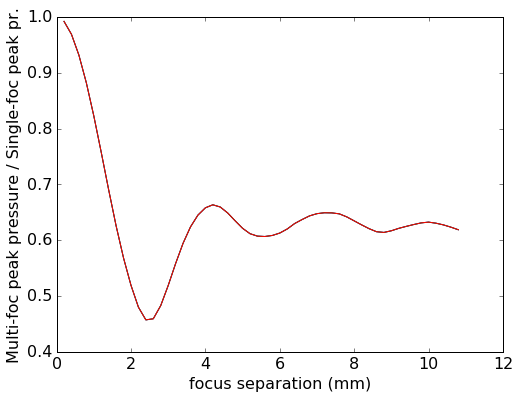

In [309]:
plt.figure(figsize=(8,6))
plt.plot(mf_radii*1000, ratios )
plt.xlabel('focus separation (mm)',fontsize=16)
plt.ylabel('Multi-foc peak pressure / Single-foc peak pr.',fontsize=16)
plt.gca().tick_params(labelsize=16)

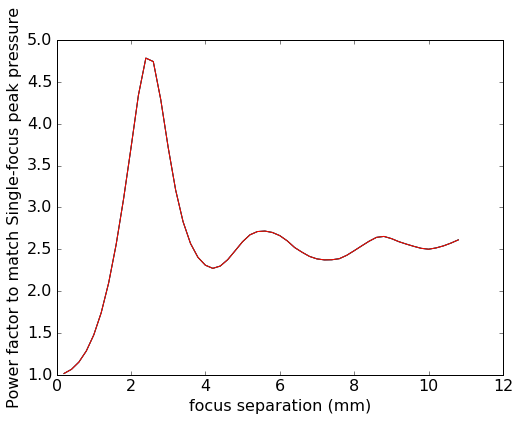

In [310]:
plt.figure(figsize=(8,6))
plt.plot(mf_radii*1000, 1./ratios**2 )
plt.xlabel('focus separation (mm)',fontsize=16)
plt.ylabel('Power factor to match Single-focus peak pressure',fontsize=16)
plt.gca().tick_params(labelsize=16)

In [44]:
T[0] = 37.0
CEM[:]=0
tstarts = np.arange(0,30,1.0)
ablation_utils.sonicate4D(simPhysGrid,tstarts[0:-1],tstarts[1:], uamp1, uxyz,unvec, use_gpu=True, CEM=CEM, calcField=False,
                          RSkeys={'subsampN':10,'ROC':0.14,'subsampDiam':0.0033}, 
                          PBkeys={'Freeflow':1,'GPU':True}, verbose=True );

 29/ 29, 100% 

In [460]:
RSkeys=dict(subsampN=10, ROC=0.14, subsampDiam=0.0033, gpublocks=512)
dxcm = 0.01
dycm = 0.01
xx= 1e-2*np.arange(-1.0,1.0, dxcm, dtype=dataType)
yy= 1e-2*np.arange(-1.0,1.0, dycm, dtype=dataType)

#uuu = transducers.get_focused_element_vals(simPhysGrid['k0'], uxyz, geom.ring(0.004,3,z=0.14)[0], [1,1,1], L1renorm=sqrt(powRenorm) )
uuu = transducers.get_focused_element_vals(simPhysGrid['k0'], uxyz, [[0.0, 0.00,0.14]], [1], L2renorm=L2powRenorm )

ppfplane0 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, uamp, xx, yy, [0.14], **RSkeys)  
ppfplane1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, uuu, xx, yy, [0.14], **RSkeys)  

Ifp0 = np.abs(ppfplane0.squeeze())**2 / (2.0*1000.0*1540)
Ifp1 = np.abs(ppfplane1.squeeze())**2 / (2.0*1000.0*1540)

In [437]:
xxt= 1e-2*np.arange(-3.0,3.0, 0.01, dtype=dataType)

aaNun = np.ones([256])/256
pcalib = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, aaNun, xxt, [0.], [0.14], **RSkeys)
desiredI = 1e7
calibrationGain = desiredI/(np.max(np.abs(pcalib)**2)/(2*rho*c0))
 
aaN = aaNun*sqrt(calibrationGain)
Igain = 2.45
#bbN = aaN 
L2A=sqrt(Igain * np.sum(np.abs(aaN)**2))
bbN = transducers.get_focused_element_vals(simPhysGrid['k0'], uxyz, geom.ring(0.008,3,z=0.14)[0], [1,1,1], L2renorm=L2A )
#A = Igain * np.sum(np.abs(aaN)**2) / np.sum(np.abs(bbN)**2)
#bbN = bbN*sqrt(A)

ppfA = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, aaN, xxt, [0.], [0.14], **RSkeys).squeeze()
ppfB = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, bbN, xxt, [0.], [0.14], **RSkeys).squeeze()  

ds=0.1
xtotalInt= 1e-2*np.arange(-8.0,8.0, ds, dtype=dataType)
ytotalInt= xtotalInt
ztotalInt= 1e-2*np.arange(-1,14.0, ds, dtype=dataType)

In [221]:
np.sum(np.abs(aaN)**2)

120327127229.13963

In [458]:
ampsvec=uamp
SXY1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, ampsvec, xtotalInt, ytotalInt, ztotalInt[[0]], **RSkeys)
SXY2 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, ampsvec, xtotalInt, ytotalInt, ztotalInt[[-1]], **RSkeys)
SYZ1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, ampsvec, xtotalInt[[0]], ytotalInt, ztotalInt, **RSkeys)
SYZ2 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, ampsvec, xtotalInt[[-1]], ytotalInt, ztotalInt, **RSkeys)
valA = np.sum(2*(np.abs(SYZ1)**2 + np.abs(SYZ2)**2) + np.abs(SXY1)**2 + np.abs(SXY2)**2) 

ampsvec=uamp1
SXY1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, ampsvec, xtotalInt, ytotalInt, ztotalInt[[0]], **RSkeys)
SXY2 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, ampsvec, xtotalInt, ytotalInt, ztotalInt[[-1]], **RSkeys)
SYZ1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, ampsvec, xtotalInt[[0]], ytotalInt, ztotalInt, **RSkeys)
SYZ2 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, ampsvec, xtotalInt[[-1]], ytotalInt, ztotalInt, **RSkeys)
valB = np.sum(2*(np.abs(SYZ1)**2 + np.abs(SYZ2)**2) + np.abs(SXY1)**2 + np.abs(SXY2)**2) 

In [459]:
valB / valA

0.98443756938297133

In [297]:
np.max(np.abs(ppfA)**2)/(2*rho*c0)

10000000.00000003

In [293]:
np.sum(np.abs(bbN)**2) / np.sum(np.abs(aaN)**2),  np.sum(np.abs(ppfB)**2)/np.sum(np.abs(ppfA)**2)

(2.4499999999999988, 0.95368303750788119)

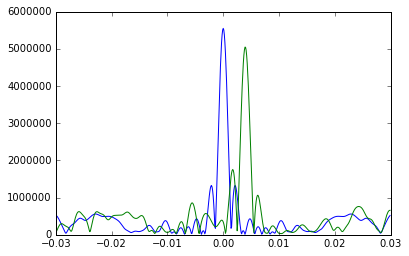

In [381]:
plt.plot(xxt,np.abs(ppfA))
plt.plot(xxt,np.abs(ppfB))


In [165]:
valB / valA

1.3141477491809319

In [300]:
def gauss2d(x,y,sigmaX,sigmaY,x0=0.0,y0=0.0):
    return (1/(2*pi*sigmaX*sigmaY)) * ( np.exp(-(x-x0)**2 / (2*sigmaX**2))  *  np.exp(-(y-y0)**2 / (2*sigmaY**2))    )



kpx= 1e-2*np.arange(-0.5,0.5, dxcm, dtype=dataType)
kpy= 1e-2*np.arange(-0.5,0.5, dycm, dtype=dataType)

mx,my=np.meshgrid( kpx, kpy, indexing='ij' )

kernel = gauss2d(mx,my, 0.0005, 0.0005)*dxcm*dycm*1e-4

In [264]:
from scipy import ndimage

In [301]:
Ifp0conv = ndimage.convolve(Ifp0,kernel)
Ifp1conv = ndimage.convolve(Ifp1,kernel)

In [283]:
dxcm*dycm*1e-4

1e-08

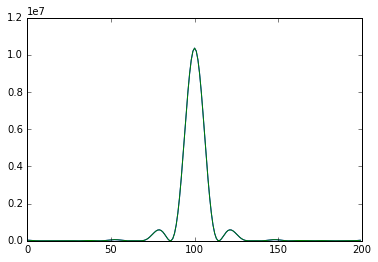

In [461]:
plt.plot(Ifp0[100,:])
plt.plot(Ifp1[100,:])



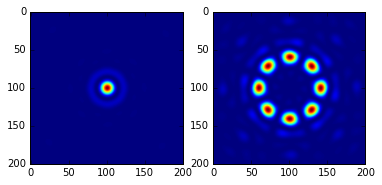

In [449]:
plt.subplot(121)
plt.imshow(Ifp0)
plt.subplot(122)
plt.imshow(Ifp1)

In [228]:
T[0] = 37.0
CEM[:]=0
tstarts = np.arange(0,30,1.0)
ablation_utils.sonicate4D(simPhysGrid,tstarts[0:-1],tstarts[1:], uamp1, uxyz,unvec, use_gpu=True, CEM=CEM, calcField=True,
                          RSkeys={'subsampN':10,'ROC':0.14,'subsampDiam':0.0033}, 
                          PBkeys={'Freeflow':1,'GPU':False}, verbose=True );

Tcpu=T[0].copy()

T[0] = 37.0
CEM[:]=0
tstarts = np.arange(0,30,1.0)
ablation_utils.sonicate4D(simPhysGrid,tstarts[0:-1],tstarts[1:], uamp1, uxyz,unvec, use_gpu=True, CEM=CEM, calcField=False,
                          RSkeys={'subsampN':10,'ROC':0.14,'subsampDiam':0.0033}, 
                          PBkeys={'Freeflow':1,'GPU':True}, verbose=True );
Tgpu=T[0].copy()

 29/ 29, 100% 

In [81]:
tstarts = np.arange(0,30,5.0)

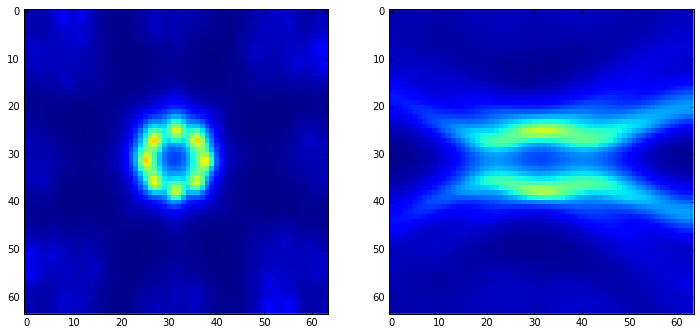

In [229]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(T[0][:,:,focplaneZpix], vmin=37.0, vmax=44.0, interpolation='none', cmap=image.cm.jet )
plt.subplot(122)
plt.imshow(T[0][:,yi,:], vmin=37.0, vmax=44.0, interpolation='none', cmap=image.cm.jet )

In [60]:
diff=(Tgpu-Tcpu)/Tcpu
np.max(diff), np.min(diff)

(0.11185051, -0.053558927)

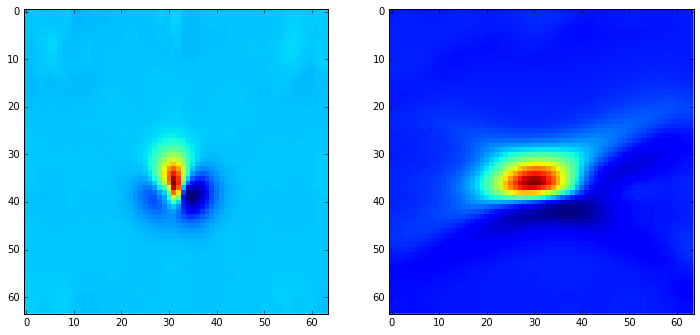

In [61]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(diff[:,:,focplaneZpix], interpolation='none', cmap=image.cm.jet )
plt.subplot(122)
plt.imshow(diff[:,yi,:], interpolation='none', cmap=image.cm.jet )

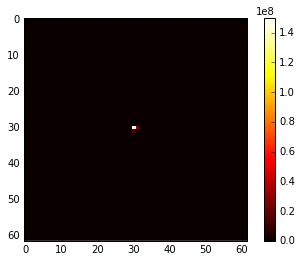

In [145]:
plt.imshow(CEM[:,:,focplaneZpix], interpolation='none', cmap=image.cm.hot )
plt.colorbar()

In [230]:
T[0] = 22.0
CEM[:]=0
interpTimes = np.arange(0.0,20.01, 1.0)
interpTemp1 = np.zeros([len(interpTimes)])
interpTemp0 = np.zeros([len(interpTimes)])

tightROI =geom.inCuboidBounds(gxp,gyp,gzp, xr=[-0.0075, 0.0075], yr=[-0.0075, 0.0075], zr=[0.125, 0.15])   
times = np.arange(0.0,25.2, 5.0)
pbheDict = {'GPU':False, 'Freeflow':1, 'interpTimes':interpTimes, 'interpolatedTemp': interpTemp0, 'interpFunc':np.mean, 'interpmask':tightROI}

ablation_utils.sonicate4D(simPhysGrid,times[0:-1],times[1:],uamp,uxyz,unvec, use_gpu=True, CEM=CEM, verbose=True,
                          RSkeys={'subsampN':10,'ROC':0.14,'subsampDiam':0.0033,'gpublocks':256}, 
                          PBkeys=pbheDict,alpha_acc=1);
T[0] = 22.0
pbheDict['interpolatedTemp']=interpTemp1
ablation_utils.sonicate4D(simPhysGrid,times[0:-1],times[1:],uamp1,uxyz,unvec, use_gpu=True, CEM=CEM, verbose=True,
                          RSkeys={'subsampN':10,'ROC':0.14,'subsampDiam':0.0033,'gpublocks':256}, 
                          PBkeys=pbheDict,alpha_acc=1);

  5/  5, 100% 

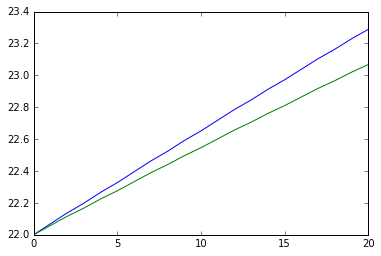

In [231]:
plt.plot(interpTemp0)
plt.plot(interpTemp1)

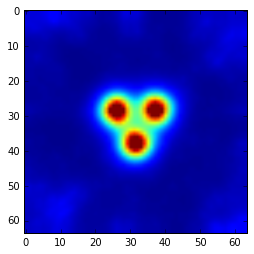

In [65]:
plt.imshow(T[0][:,:,focplaneZpix],vmin=22.,vmax=60)

In [11]:
passTime = ablation_utils.trajTotalTime(*tuple(traj))

In [33]:
staticTraj=[0.0, 4.0, 140.0, 0.3, 9.25, 2.0]
(coords,nturns,numson)=ablation_utils.contstruct_circ_sonication_points(*tuple(staticTraj))

In [35]:
nturns

0

In [67]:
def makeFileDescriptor(traj=None, I=None,Npass=None,M=None,d=None):
    sp = traj[3]
    dw = traj[4]
    return ( 'sp=%0.2f_dw=%0.2f_I=%4d_d=%0.1f_N=%s_Np=%d' % (sp,dw,I*1e-4,d*1e3,M,Npass) )

def roimaskSpatialAvg(data,mask):
    return np.array(list(map( lambda plane: np.mean(plane[mask]), data)) )

d=0.0025
d_mm=d*1e3
pxyz,r = geom.ring(d,3)
#pxyz=[[0.0, 0.0, 0.0]]

T0=22.0
alpha_acc=8.0

T[0] = T0
CEM[:]=0
#traj=[10.0, 4.0, 140.0, 0.3, 9.25, 2.0]
traj=[10.0, 4.0, 140.0, 2.0, 2.5, 0.0]
#traj=[10.0, 4.0, 140.0, 1.25, 1.0, 0.0]

Npass=3

focusN = [5,3,1]
focusd_mm =[2.25, 5.0, 0]

#focusN=[3]
#focusd_mm=[4.0]

#focusd_mm = [d_mm, d_mm, d_mm]

focusDesc="".join(map(lambda x:'%s'%x,focusN))
focusSet = []
for n in range(0,Npass):
    if focusN[n] > 1:
        pp,rr = geom.ring( focusd_mm[n]*1e-3, focusN[n] )
    else:
        pp=None
        
    focusSet.append(pp)


RR = 4*np.ones_like(T[0])
def temp2cem(temp3d ):
    RR[temp3d>43]=2.0
    return (RR**(temp3d-43))

passTime = ablation_utils.trajTotalTime(*tuple(traj)) + traj[-1]
totTime=Npass*passTime

(coords,nturns,numson)=ablation_utils.contstruct_circ_sonication_points(*tuple(traj))

interpTimes = np.arange(0,totTime, .33)
interpTemp = np.zeros([len(interpTimes)])
interpTempFocPlane = np.zeros([len(interpTimes), nx,ny])
interpCEMFocPlane = np.zeros_like(interpTempFocPlane)

interpCEMFocAxial = np.zeros([len(interpTimes), nx,nz])
interpTempAxial = np.zeros_like(interpCEMFocAxial)

interp240Vol = np.zeros([len(interpTimes)])
interp240VolON = np.zeros([len(interpTimes)])
#interp240VolOFF = np.zeros([len(interpTimes)])
#interpoDose = np.zeros([len(interpTimes)])

yi=floor(ny/2)

def calcDosageIntegrands(temp3d):
    tidx=calcDosageIntegrands.idx  
    #interpoDose[calcDosageIntegrands.idx] = np.max( temp2cem(temp3d) )
    calcDosageIntegrands.out1[calcDosageIntegrands.idx] = temp3d[:,:,focplaneZpix] 
    calcDosageIntegrands.out2[calcDosageIntegrands.idx] = CEM[:,:,focplaneZpix]
    calcDosageIntegrands.out3[calcDosageIntegrands.idx] = CEM[:,yi,:]
    calcDosageIntegrands.out4[calcDosageIntegrands.idx] = temp3d[:,yi,:] 
    calcDosageIntegrands.vol240[calcDosageIntegrands.idx] = np.sum( CEM>=240.0 )
    calcDosageIntegrands.vol240ON[calcDosageIntegrands.idx] = np.sum( CEM[ROION]>=240.0 )
    
    return np.mean(temp3d)

calcDosageIntegrands.idx=0
calcDosageIntegrands.out1 = interpTempFocPlane
calcDosageIntegrands.out2=  interpCEMFocPlane
calcDosageIntegrands.out3=  interpCEMFocAxial
calcDosageIntegrands.out4=  interpTempAxial

calcDosageIntegrands.vol240= interp240Vol
calcDosageIntegrands.vol240ON= interp240VolON

pbheDict = dict(Freeflow=0, interpTimes=interpTimes, interpolatedTemp=interpTemp, interpFunc=calcDosageIntegrands, perfRate=0.0)

RaylSommDict = dict(subsampN=10,ROC=0.14,subsampDiam=0.0066,gpublocks=512)

(junk,junk,npt)=ablation_utils.contstruct_circ_sonication_points(*traj)
for n in range(0,Npass):
    print("Pass %d / %d" %(n+1,Npass), end='\n')
    
    dangle=n*2*pi/(npt[1]*Npass)
    Ry_n = geom.getRotZYZarray(dangle, pi*n, 0.0)
    #Ry_n = None
    pxyz=focusSet[n]
    
    (times,focalpoint_coords_mm,CEM)=ablation_utils.trajectorySonication(traj, simPhysGrid, use_gpu=True, pxyz=pxyz, 
                                                    L1renorm=sqrt(powRenorm), CEM=CEM, verbose=True, Npass=1, alpha_acc=alpha_acc,
                                                    RSkeys=RaylSommDict,tzero=n*passTime,PathRotMat=Ry_n,
                                                    PBkeys=pbheDict )
    


Pass 1 / 3
 22/ 22, 100% Pass 2 / 3
 22/ 22, 100% Pass 3 / 3
 22/ 22, 100% 

In [113]:
(junk,junk,npt)=ablation_utils.contstruct_circ_sonication_points(*traj)

In [37]:
transducers.subsample_transducer_array(uxyz,0.0033,9,ROC=0.14)

(array([[-0.0219294 , -0.0117387 ,  0.0022274 ],
        [-0.0202794 , -0.0117387 ,  0.00223712],
        [-0.02090064, -0.01044868,  0.00223712],
        ..., 
        [-0.0664824 ,  0.01201219,  0.01666652],
        [-0.06536296,  0.01111947,  0.01666652],
        [-0.06396704,  0.01143808,  0.01666652]]), 8, [])

In [68]:
interpTemp0 = np.zeros([len(interpTimes)])
interpTempFocPlane0 = np.zeros([len(interpTimes), nx,ny])
interpCEMFocPlane0 = np.zeros_like(interpTempFocPlane0)
interpCEMFocAxial0 = np.zeros([len(interpTimes), nx,nz])
interpTempAxial0 = np.zeros_like(interpCEMFocAxial0)

interp240Vol0 = np.zeros([len(interpTimes)])
interp240VolON0 = np.zeros([len(interpTimes)])

pbheDict['interpolatedTemp'] = interpTemp0

calcDosageIntegrands.idx=0
calcDosageIntegrands.out1 = interpTempFocPlane0
calcDosageIntegrands.out2=  interpCEMFocPlane0
calcDosageIntegrands.out3=  interpCEMFocAxial0
calcDosageIntegrands.out4=  interpTempAxial0
calcDosageIntegrands.vol240= interp240Vol0
calcDosageIntegrands.vol240ON= interp240VolON0

T[0]= T0
CEM[:]=0

for n in range(0,Npass):
    print("Pass %d / %d" %(n+1,Npass), end='\n')
    
    
    dangle=n*2*pi/(npt[1]*Npass)
    Ry_n = geom.getRotZYZarray(dangle, pi*n, 0.0)
    #Ry_n = None
    
    (times,focalpoint_coords_mm,CEM)=ablation_utils.trajectorySonication(traj, simPhysGrid, use_gpu=True, pxyz=None,
                                                L1renorm=sqrt(powRenorm), CEM=CEM, verbose=True, Npass=1, alpha_acc=alpha_acc,
                                                RSkeys=RaylSommDict, tzero=n*passTime,PathRotMat=Ry_n,
                                                PBkeys=pbheDict )

Pass 1 / 3
 22/ 22, 100% Pass 2 / 3
  4/ 22, 18% 

  CEM[:] += (dt/60.0)*np.sum( Rbase**(T[0:buffsize]-43), 0  )



 22/ 22, 100% Pass 3 / 3
 22/ 22, 100% 

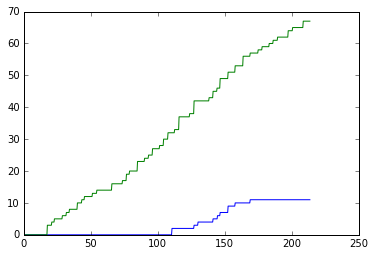

In [9]:
plt.plot(interpTimes, np.sum(interpCEMFocPlane >=240,axis=(1,2)))
plt.plot(interpTimes, np.sum(interpCEMFocPlane0 >=240,axis=(1,2)))

In [367]:
interpTempFocPlane[:,ROION[:,:,focplaneZpix]].shape

(66, 468)

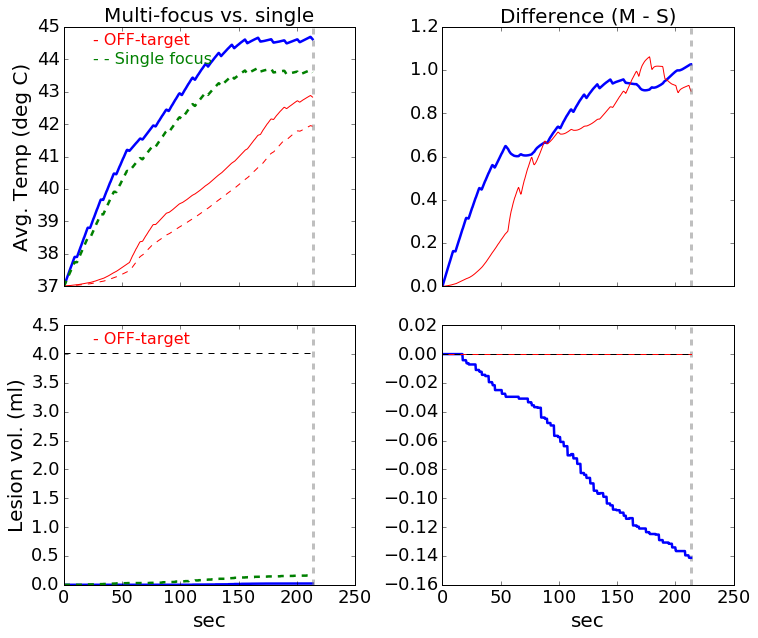

In [10]:


focplaneONAvg=roimaskSpatialAvg( interpTempFocPlane, ROION[:,:,focplaneZpix])
focplaneOFFAvg=roimaskSpatialAvg( interpTempFocPlane, ROIOFF[:,:,focplaneZpix])
focplaneONAvg0=roimaskSpatialAvg( interpTempFocPlane0, ROION[:,:,focplaneZpix])
focplaneOFFAvg0=roimaskSpatialAvg( interpTempFocPlane0, ROIOFF[:,:,focplaneZpix])

fig,axTable=plt.subplots(nrows=2,ncols=2,sharey=False,sharex=True,squeeze=False,gridspec_kw=dict(wspace=0.3,hspace=0.15), figsize=(12,10))

#plt.figure(figsize=(10,10))
#ax=plt.subplot(221)

axTable[0,0].set_title('Multi-focus vs. single', fontsize=20)
axTable[0,1].set_title('Difference (M - S)', fontsize=20)

ax=axTable[0,0]

#ax.set_xlabel('sec', fontsize=20)
ax.set_ylabel('Avg. Temp (deg C)', fontsize=20)
ax.tick_params(labelsize=18)

multicolor=(0,0,0.8)
pl=ax.plot(interpTimes, focplaneONAvg, '-',color='blue', linewidth=2.5  )
ax.plot(interpTimes, focplaneOFFAvg, color='red' )

ax.plot(interpTimes, focplaneONAvg0, '--',color='green', linewidth=2.5 )
ax.plot(interpTimes, focplaneOFFAvg0, '--',color='red', linewidth=1.0 )

plt.text(0.1, 0.93, '- OFF-target',transform=ax.transAxes, fontsize=16,fontdict=dict(color='red'))
plt.text(0.1, 0.86, '- - Single focus',transform=ax.transAxes, fontsize=16,fontdict=dict(color='green'))

#ax2=plt.subplot(222)
#ax2.set_ylim(bottom=ax.get_ylim()[0], top=ax.get_ylim()[1])

ax2=axTable[0,1]
#ax2.set_xlabel('sec', fontsize=20)
ax2.tick_params(labelsize=18)
pl=ax2.plot(interpTimes, focplaneONAvg - focplaneONAvg0, '-',color='blue', linewidth=2.5 )
ax2.plot(interpTimes, focplaneOFFAvg - focplaneOFFAvg0, '-',color='red', linewidth=1.0 )

vlineOpt = dict(color=[0.5, 0.5, 0.5], linestyle='--',linewidth=3.0,alpha=0.5)
for n in range(1,Npass+1):
    ax.axvline(x=passTime*n, **vlineOpt)
    ax2.axvline(x=passTime*n, **vlineOpt)
    
    
    
voxVolmL=(dx*dy*dz)*1e9*1e-3
totOnVol=voxVolmL*np.sum(ROION)

ax=axTable[1,0]
#ax=plt.subplot(223)
ax.set_xlabel('sec', fontsize=20)
ax.set_ylabel('Lesion vol. (ml)', fontsize=20)
ax.tick_params(labelsize=18)
multicolor=(0,0,0.8)
ax.plot(interpTimes, voxVolmL*interp240VolON, '-',color='blue', linewidth=2.5  )
ax.plot(interpTimes, voxVolmL*(interp240Vol - interp240VolON), color='red' )
ax.plot(interpTimes, voxVolmL*(interp240Vol0 - interp240VolON0), '--',color='red', linewidth=1.0 )
ax.plot(interpTimes, voxVolmL*interp240VolON0, '--',color='green', linewidth=2.5 )

ax.plot(interpTimes[[0,-1]], [totOnVol,totOnVol], '--k')
plt.text(0.1, 0.93, '- OFF-target',transform=ax.transAxes, fontsize=16,fontdict=dict(color='red'))

ax2=axTable[1,1]
#ax2=plt.subplot(224)
#ax2.set_ylim(bottom=0.0, top=ax.get_ylim()[1])
ax2.set_xlabel('sec', fontsize=20)
ax2.tick_params(labelsize=18)

vlineOpt = dict(color=[0.5, 0.5, 0.5], linestyle='--',linewidth=3.0,alpha=0.5)
for n in range(1,Npass+1):
    ax.axvline(x=passTime*n, **vlineOpt)
    ax2.axvline(x=passTime*n, **vlineOpt)

#plt.plot(interpTimes, interp240Vol0, '--', color='0.0', linewidth=1.0 )
ax2.plot(interpTimes, voxVolmL*(interp240VolON-interp240VolON0), '-',color='blue', linewidth=2.5 )
ax2.plot(interpTimes, voxVolmL*(interp240Vol - interp240VolON - (interp240Vol0 - interp240VolON0)), color='red', linewidth=1.0 )
ax2.plot(interpTimes[[0,-1]], [0,0], '--k')

In [69]:
outdir='C:\\Users\\Vandiver\\Documents\\HiFU\\code\\AblationSims\\trajectory_compare\\'
makeFileDescriptor(traj=traj, I=Ispta0,Npass=Npass,M=focusDesc,d=d)



[10.0, 4.0, 140.0, 1.25, 1.0, 0.0]

In [27]:
interpTimes[15]

4.9500000000000002

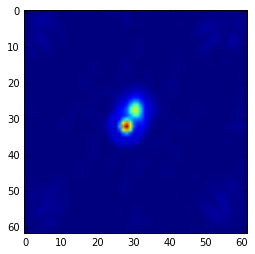

In [28]:
plt.imshow( interpTempFocPlane[15] )

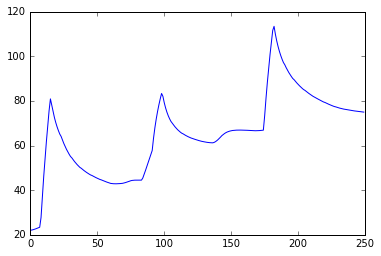

In [31]:
plt.plot(interpTempFocPlane[:,33,28])

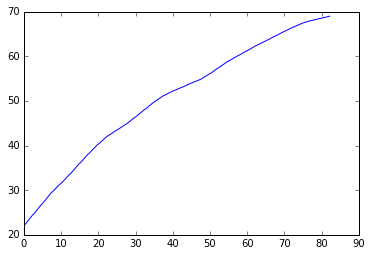

In [19]:
focplaneONAvg=roimaskSpatialAvg( interpTempFocPlane, ROION[:,:,focplaneZpix])
plt.plot( interpTimes, focplaneONAvg )

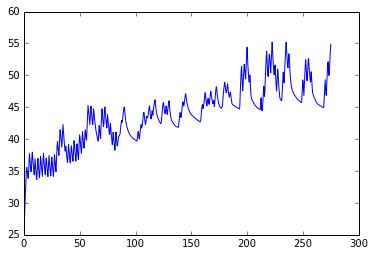

In [25]:
plt.plot(interpTimes,interpTemp)

In [ ]:
np.

In [11]:
def createFigureAnimator(tempStack, tempAxialStack, cemStack, cemAxialStack):

    extXY = 100*np.array( [yrp[0],yrp[-1],xrp[-1],xrp[0]] )
    extZX = 100*np.array( [zrp[0],zrp[-1],xrp[-1],xrp[0]] )

    fig,axTable=plt.subplots(nrows=2,ncols=2,sharey=True,sharex=False,squeeze=False,gridspec_kw=dict(wspace=0.05,hspace=0.1), figsize=(14,14))

    ax=axTable[0,0]
    im=ax.imshow(tempStack[-1,:,:], vmin=37.0, vmax=50.0,cmap=image.cm.hot,interpolation='none', extent=extXY)
    ax.imshow( ROION[:,:,focplaneZpix] , extent=extXY, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
    ax.plot(coords[:,1] /10,coords[:,0]/10,'--o')
    cb=plt.colorbar(orientation='horizontal',mappable=im,ax=ax, ticks = np.arange( *(im.get_clim() +(3,)) ) )
    cb.set_label('C',fontsize=20)
    cb.ax.tick_params(labelsize=20)
    ax.set_ylabel('cm', fontsize=20)
    
    txtLab=plt.text(0.5, 0.93, '0.0',transform=ax.transAxes, fontsize=16,fontdict=dict(color='yellow'))

    ax=axTable[0,1]
    im2=ax.imshow(cemStack[-1,:,:], vmin=0.0, vmax=240.0,cmap=image.cm.hot,interpolation='none', extent=extXY)
    ax.imshow( ROION[:,:,focplaneZpix] , extent=extXY, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
    cb=plt.colorbar(orientation='horizontal',mappable=im2,ax=ax,ticks=[0,40,80,120,160,200,240])
    cb.set_label('CEM',fontsize=20)
    cb.ax.tick_params(labelsize=20)

    ax=axTable[1,0]
    imT=ax.imshow(tempAxialStack[-1,:,:], vmin=37.0, vmax=50.0, cmap=image.cm.hot,interpolation='none', extent=extZX)
    ax.imshow( ROION[:,yi,:] ,vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none',  extent=extZX)
    cb=plt.colorbar(orientation='horizontal',mappable=imT, ax=ax, ticks = np.arange( *(im.get_clim() +(3,)) ) )
    cb.set_label('CEM',fontsize=20)
    cb.ax.tick_params(labelsize=20)
    ax.set_ylabel('cm', fontsize=20)

    ax=axTable[1,1]
    im3=ax.imshow(cemAxialStack[-1,:,:], vmin=0.0, vmax=240.0,cmap=image.cm.hot,interpolation='none', extent=extZX)
    ax.imshow( ROION[:,yi,:] , extent=extZX, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
    cb=plt.colorbar(orientation='horizontal',mappable=im3,ax=ax,ticks=[0,40,80,120,160,200,240])
    cb.set_label('CEM',fontsize=20)
    cb.ax.tick_params(labelsize=20)

    for ax in axTable.flatten():
        ax.set_xlabel('cm', fontsize=20)
        ax.tick_params(labelsize=18)

    clipDuration=interpTimes[-1]*0.1
    numUniqueFrames=cemStack.shape[0]
    def makeframe(t):
        t/clipDuration
        ti= int(np.floor( numUniqueFrames*t/clipDuration ))
        im.set_data(tempStack[ti,:,:]);
        imT.set_data(tempAxialStack[ti,:,:]);
        im2.set_data(cemStack[ti,:,:]);
        im3.set_data(cemAxialStack[ti,:,:]);
        txtLab.set_text('%0.1f'% interpTimes[ti])
        return mplfig_to_npimage(fig)
    
    animation =mpy.VideoClip(makeframe, duration=clipDuration);
    
    return (makeframe, animation, fig)
    

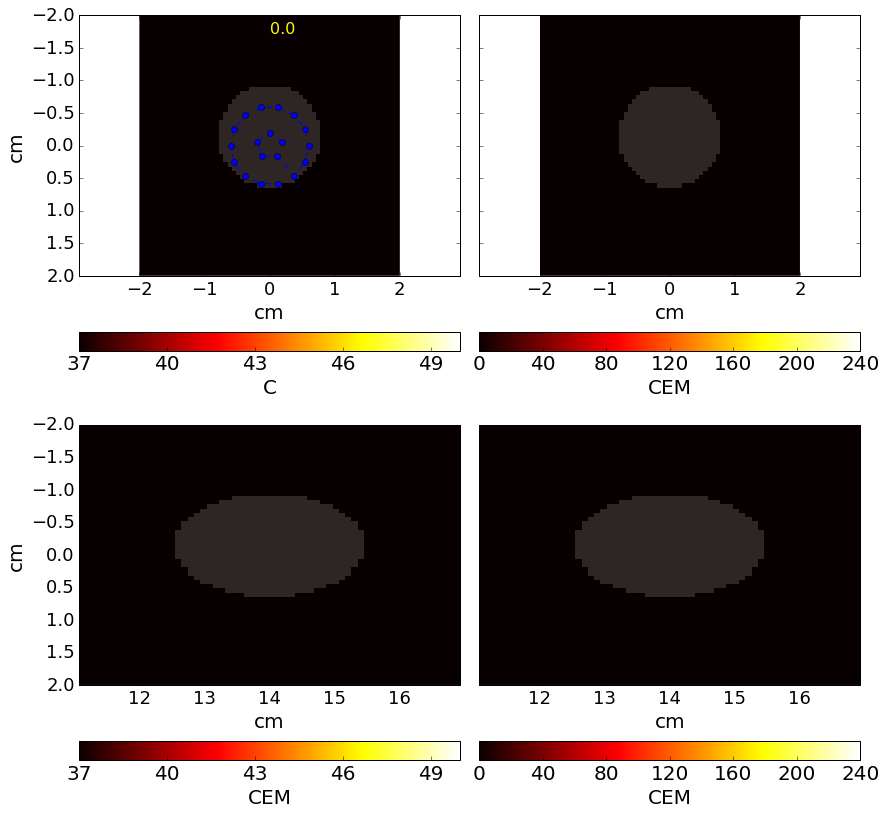

In [12]:
mf0, anim0, fig0= createFigureAnimator( interpTempFocPlane0, interpTempAxial0, interpCEMFocPlane0, interpCEMFocAxial0);

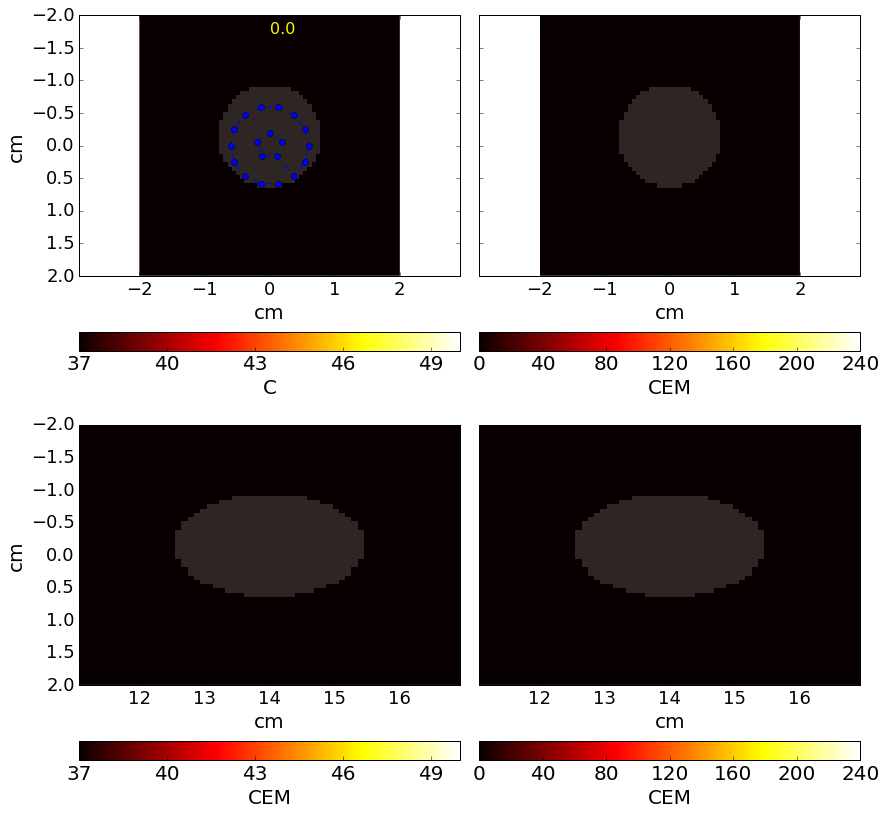

In [13]:
mf1, anim1,fig1 = createFigureAnimator( interpTempFocPlane, interpTempAxial, interpCEMFocPlane, interpCEMFocAxial)

In [103]:
traj

[10.0, 4.0, 140.0, 2.0, 2.5, 0.0]

In [14]:
outdir='C:\\Users\\Vandiver\\Documents\\HiFU\\code\\AblationSims\\trajectory_compare\\'
#anim0.write_videofile(outdir+'test0.mp4',fps=20)
anim0.write_videofile(outdir+'sp=0.3_dw=9.25_AI=10_d=0mm_N=1_Np=1.mp4',fps=20)
anim1.write_videofile(outdir+'sp=0.3_dw=9.25_AI=10_d=2.5mm_N=3_Np=1.mp4',fps=20)
#animation.write_videofile(outdir+'test1_I=2500_d=2.5mm_N=5.mp4',fps=20)

[MoviePy] >>>> Building video C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=0.3_dw=9.25_AI=10_d=0mm_N=1_Np=1.mp4
[MoviePy] Writing video C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=0.3_dw=9.25_AI=10_d=0mm_N=1_Np=1.mp4


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=0.3_dw=9.25_AI=10_d=0mm_N=1_Np=1.mp4 

[MoviePy] >>>> Building video C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=0.3_dw=9.25_AI=10_d=2.5mm_N=3_Np=1.mp4
[MoviePy] Writing video C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=0.3_dw=9.25_AI=10_d=2.5mm_N=3_Np=1.mp4


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Vandiver\Documents\HiFU\code\AblationSims\trajectory_compare\sp=0.3_dw=9.25_AI=10_d=2.5mm_N=3_Np=1.mp4 



In [20]:
tp1=np.where(interpTimes[1:]>=passTime)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

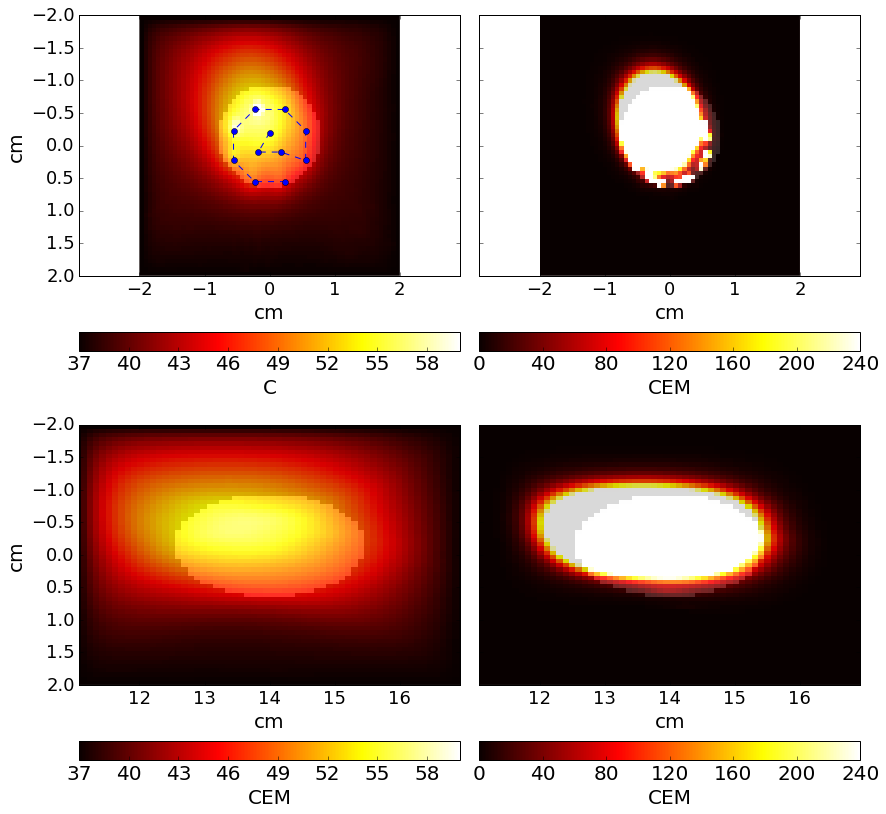

In [35]:
tempStack=interpTempFocPlane
tempAxialStack=interpTempAxial
cemStack=interpCEMFocPlane
cemAxialStack=interpCEMFocAxial
extXY = 100*np.array( [yrp[0],yrp[-1],xrp[-1],xrp[0]] )
extZX = 100*np.array( [zrp[0],zrp[-1],xrp[-1],xrp[0]] )

fig,axTable=plt.subplots(nrows=2,ncols=2,sharey=True,sharex=False,squeeze=False,gridspec_kw=dict(wspace=0.05,hspace=0.1), figsize=(14,14))


ti=-1

ax=axTable[0,0]
im=ax.imshow(tempStack[ti,:,:], vmin=T0, vmax=60.0,cmap=image.cm.hot,interpolation='none', extent=extXY)
ax.imshow( ROION[:,:,focplaneZpix] , extent=extXY, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
ax.plot(coords[:,1] /10,coords[:,0]/10,'--o')
cb=plt.colorbar(orientation='horizontal',mappable=im,ax=ax, ticks = np.arange( *(im.get_clim() +(3,)) ) )
cb.set_label('C',fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_ylabel('cm', fontsize=20)

ax=axTable[0,1]
im2=ax.imshow(cemStack[ti,:,:], vmin=0.0, vmax=240.0,cmap=image.cm.hot,interpolation='none', extent=extXY)
ax.imshow( ROION[:,:,focplaneZpix] , extent=extXY, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
cb=plt.colorbar(orientation='horizontal',mappable=im2,ax=ax,ticks=[0,40,80,120,160,200,240])
cb.set_label('CEM',fontsize=20)
cb.ax.tick_params(labelsize=20)

ax=axTable[1,0]
imT=ax.imshow(tempAxialStack[ti,:,:], vmin=T0, vmax=60.0, cmap=image.cm.hot,interpolation='none', extent=extZX)
ax.imshow( ROION[:,yi,:] ,vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none',  extent=extZX)
cb=plt.colorbar(orientation='horizontal',mappable=imT, ax=ax, ticks = np.arange( *(im.get_clim() +(3,)) ) )
cb.set_label('CEM',fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_ylabel('cm', fontsize=20)

ax=axTable[1,1]
im3=ax.imshow(cemAxialStack[ti,:,:], vmin=0.0, vmax=240.0,cmap=image.cm.hot,interpolation='none', extent=extZX)
ax.imshow( ROION[:,yi,:] , extent=extZX, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')
cb=plt.colorbar(orientation='horizontal',mappable=im3,ax=ax,ticks=[0,40,80,120,160,200,240])
cb.set_label('CEM',fontsize=20)
cb.ax.tick_params(labelsize=20)

for ax in axTable.flatten():
    ax.set_xlabel('cm', fontsize=20)
    ax.tick_params(labelsize=18)

  if __name__ == '__main__':



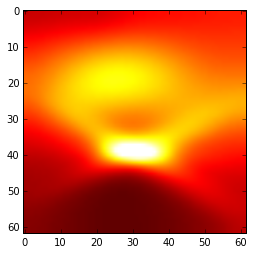

In [33]:
plt.imshow(T[0,:,ny/2,:],vmin=25,vmax=50,cmap=image.cm.hot)

In [32]:
extZX = 100*np.array( [zrp[0],zrp[-1],xrp[-1],xrp[0]] )

pxyz,r = geom.ring(0.0025,5)
uamp1 = transducers.get_focused_element_vals(simPhysGrid['k0'],uxyz, pxyz+[0.0, 0., 0.14], np.ones(len(pxyz)), L1renorm=sqrt(powRenorm) ) 
pp1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'],uxyz,unvec,uamp1,xrp,yrp,zrp,subsampN=10,ROC=0.14,subsampDiam=0.0033, gpublocks=512)  
Ip1 = np.abs(pp1)**2 / (rho*c0)

  from ipykernel import kernelapp as app



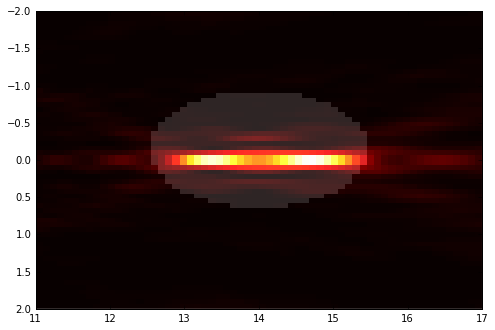

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(Ip1[:,ny/2,:],cmap=image.cm.hot,interpolation='none',extent=extZX)
plt.imshow( ROION[:,yi,:] , extent=extZX, vmin=0,vmax=1,cmap=image.cm.gray,alpha=0.15, interpolation='none')

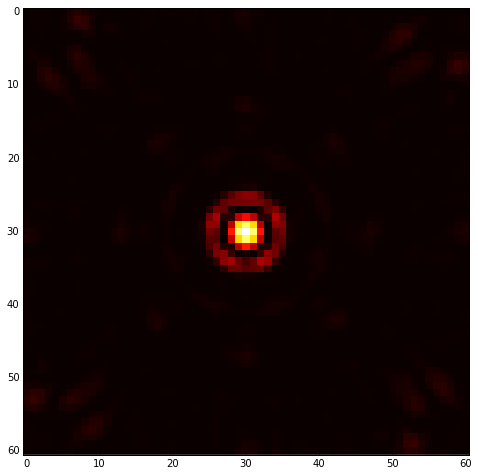

In [63]:
plt.figure(figsize=(8,8))
plt.imshow(Ip1[:,:,focplaneZpix],cmap=image.cm.hot,interpolation='none')

  if __name__ == '__main__':

  from ipykernel import kernelapp as app



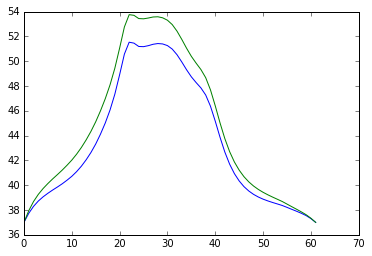

In [34]:
plt.plot( interpTempFocPlane0[-1,nx/2,:] )
plt.plot( interpTempFocPlane[-1,nx/2,:] )

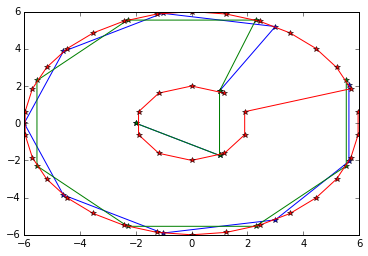

In [76]:
plotTraj([1.0,4.0,0.0]);
plotTraj([2.0,2.25,2.0]);
plotTraj([1.25, 1.0, 0.0]);

In [299]:
points,nt,numSon = ablation_utils.contstruct_circ_sonication_points(10,4, 140, 0.5 , 10, 0)

In [300]:
(points - [0., 0., 140.0]).dot(Ry_n)

array([[  2.00000000e+00,   2.44929360e-16,   2.44929360e-16],
       [ -1.00000000e+00,  -1.73205081e+00,  -1.22464680e-16],
       [ -1.00000000e+00,   1.73205081e+00,  -1.22464680e-16],
       [ -2.29610059e+00,   5.54327720e+00,  -2.81191224e-16],
       [  2.29610059e+00,   5.54327720e+00,   2.81191224e-16],
       [  5.54327720e+00,   2.29610059e+00,   6.78855667e-16],
       [  5.54327720e+00,  -2.29610059e+00,   6.78855667e-16],
       [  2.29610059e+00,  -5.54327720e+00,   2.81191224e-16],
       [ -2.29610059e+00,  -5.54327720e+00,  -2.81191224e-16],
       [ -5.54327720e+00,  -2.29610059e+00,  -6.78855667e-16],
       [ -5.54327720e+00,   2.29610059e+00,  -6.78855667e-16]])

In [204]:
ablation_utils.trajTotalTime(10,4,140,3/2,3,1)

43.0

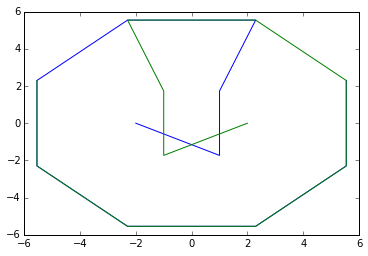

In [297]:
plt.plot(points[:,0], points[:,1])
points=points.dot(Ry_n)
plt.plot(points[:,0], points[:,1])

In [78]:
1000/1.2e6

0.0008333333333333334

In [6]:

cc=1040
f0=1.2e6
krc=f0*2*pi/cc
xx=np.linspace(-0.01, 0.01, 120)
yy=xx
zz=[0.14]

pnts= [[0.01,0,0.14], [-0.005,0,0.14]]
pnts,r=geom.ring(0.004,3,z=0.14)

uuaa = transducers.get_focused_element_vals(krc, uxyz, pnts, np.ones(len(pnts)), L1renorm=1)
#uuaa=np.ones([256])
pXY = transducers.calc_pressure_field_cuda(krc, uxyz, unvec, uuaa, xx, yy, zz, subsampN=10, ROC=0.14, subsampDiam=0.0033, gpublocks=512)  
IXY = np.abs(pXY)**2 / (2.0*rho*cc)

yy=[0.0]
zz=np.linspace(0.11, 0.16, 120)
pXZ = transducers.calc_pressure_field_cuda(krc, uxyz, unvec, uuaa, xx, yy, zz, subsampN=10, ROC=0.14, subsampDiam=0.0033, gpublocks=512)  
IXZ = np.abs(pXZ)**2 / (2.0*rho*cc)



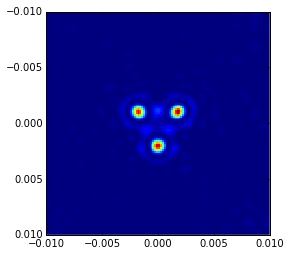

In [7]:
plt.imshow(IXY[:,:,0], interpolation='none',extent=xx[[0,-1,-1,0]])

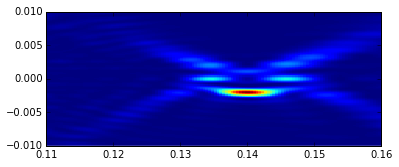

In [141]:
plt.imshow(IXZ[:,0,:], interpolation='none',extent=np.concatenate((zz[[0,-1]], xx[[0,-1]])) )  

In [29]:
ablation_utils.trajTotalTime(10.0, 4.0, 140.0, 1.25,1.0, 0)

40.0

In [30]:
ablation_utils.trajTotalTime(10.0, 4.0, 140.0, 2.0, 2.5, 0)

27.5

In [43]:
factor=3
ablation_utils.trajTotalTime(10.0, 4.0, 140.0, 1.25/factor,1.0*factor, 0), ablation_utils.countSonications(10.0, 4.0, 140.0, 1.25/factor,1.0*factor, 0)

(120.0, 40.0)

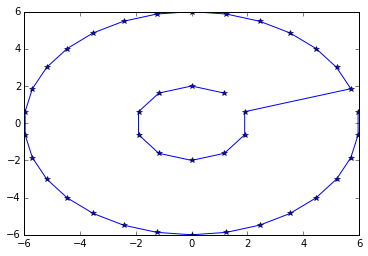

In [38]:
plotTraj([1.25/factor,1.0*factor,0.0]);

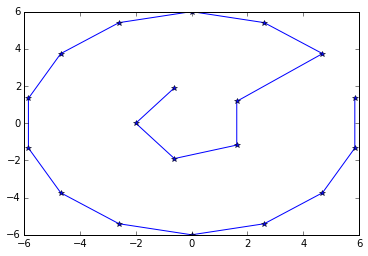

In [10]:
plotTraj(traj[3:6]);